In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2020.09.1


In [2]:
sidechain_smiles = '''c1csc([*:1])c1.C[*:2].CNC(=O)[*:3].[H][*:3]
c1csc([*:1])c1.C[*:2].CCC[*:3].[H][*:3]
c1csc([*:1])c1.C[*:2].CN(C)C(=O)[*:3].[H][*:3]
c1csc([*:1])c1.C[*:2].COC[*:3].[H][*:3]
c1csc([*:1])c1.C[*:2].O=C(O)[*:3].[H][*:3]
c1csc([*:1])c1.C[*:2].[H][*:3].[H][*:3]
c1csc([*:1])c1.C[*:2].C[*:3].[H][*:3]
c1csc([*:1])c1.C[*:2].COC(=O)[*:3].[H][*:3]
c1csc([*:1])c1.[H][*:2].CNC(=O)[*:3].[H][*:3]
c1csc([*:1])c1.[H][*:2].CCC[*:3].[H][*:3]
c1csc([*:1])c1.[H][*:2].CN(C)C(=O)[*:3].[H][*:3]
c1csc([*:1])c1.[H][*:2].COC[*:3].[H][*:3]'''.split('\n')
core_smiles = 'OC(=O)c1cc(C(=O)NC(Cc2ccc(O[*:2])cc2)[*:3])nc2ccc([*:1])cc12'
sidechains = [Chem.MolFromSmiles(x) for x in sidechain_smiles]
core = Chem.MolFromSmiles(core_smiles)

In [20]:
from rdkit import Chem
def attach_sidechains_to_core(core,sidechains):
    core_nbrs = {}
    core_ats = []
    core = Chem.RWMol(core)
    for at in core.GetAtoms():
        anum = at.GetAtomMapNum()
        if anum and at.GetDegree()==1:
            core_ats.append(at.GetIdx())
            if anum in core_nbrs:
                raise ValueError(f'atom map number {anum} found twice in the core')
            core_nbrs[anum] = at.GetNeighbors()[0]
    for anum in sorted(core_ats,reverse=True):
        core.RemoveAtom(anum)
    res = Chem.RWMol(Chem.CombineMols(core,sidechains))

    removeAts = []
    for at in res.GetAtoms():
        anum = at.GetAtomMapNum()
        if anum and at.GetDegree()==1 and anum in core_nbrs:
            nbr = at.GetNeighbors()[0]
            removeAts.append(at.GetIdx())
            res.AddBond(nbr.GetIdx(),core_nbrs[anum].GetIdx(),Chem.BondType.SINGLE)
            # if we're adding a bond to something this way, we are guaranteed to foul up the stereochem
            # representation, so just remove it
            res.GetAtomWithIdx(core_nbrs[anum].GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
    for anum in sorted(removeAts,reverse=True):
        res.RemoveAtom(anum)
    res.RemoveAllConformers()
    res = Chem.Mol(res)
    try:
        Chem.SanitizeMol(res)
    except:
        res =  None
    return res


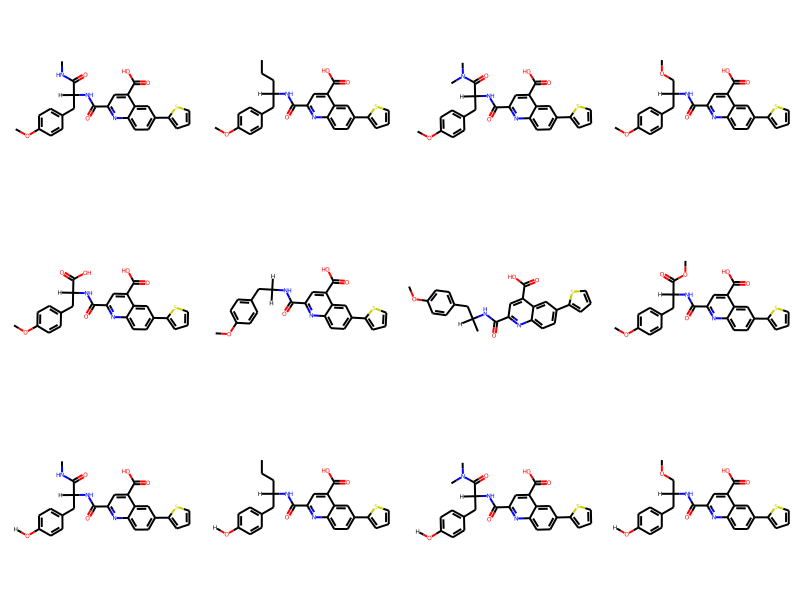

In [21]:
Draw.MolsToGridImage([attach_sidechains_to_core(core,x) for x in sidechains],molsPerRow=4)